In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib
from qiskit.test.mock import FakeAlmaden
from qiskit.ignis.verification.tomography.data import marginal_counts

In [3]:
import sys
sys.path.append('../')
import pulse_compiler_helper_fns

In [4]:
backend = FakeAlmaden()
system = q.pulse.PulseChannelSpec.from_backend(backend)
back_config = backend.configuration().to_dict()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=backend.configuration().meas_map[0])
backend_sim = qiskit.Aer.get_backend('pulse_simulator')

/Users/pranavgokhale/Developer/qiskit/qiskit-terra/qiskit/pulse/channels/pulse_channel_spec.py:87: DeprecationWarning: The PulseChannelSpec is deprecated. Use backend.configuration() instead. The supported methods require some migrations; check out the release notes for the complete details.
  DeprecationWarning)


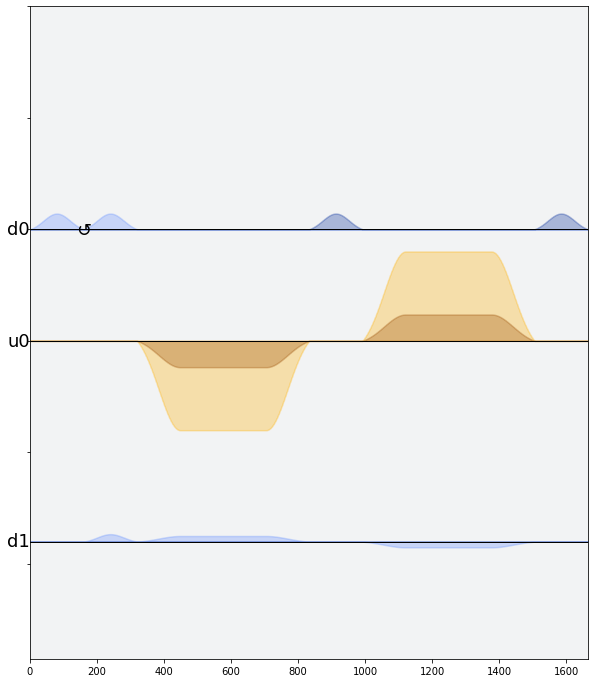

In [39]:
circuit = q.QuantumCircuit(20)
circuit.x(0)
circuit.cx(0, 1)
circuit.x(0)
decomposed_circuit = circuit.decompose()
pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
#schedule |= measure << schedule.duration

#schedule |= q.pulse.SamplePulse([0] * 160)(system.qubits[10].drive) << schedule.duration
schedule.draw(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0], ],
              framechange=True, table=False, scaling=1.3, filename='standard_open_cx.svg')

In [33]:
schedule.duration

1664

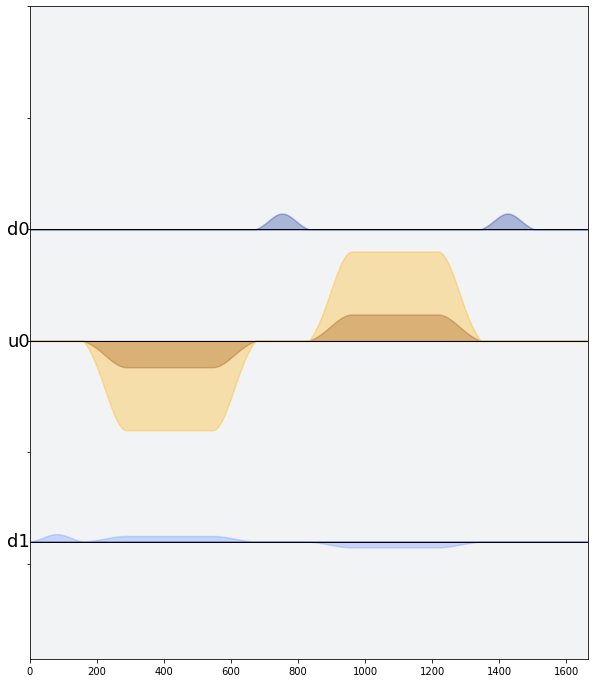

In [40]:
circuit = q.QuantumCircuit(20)
circuit.open_cx(0, 1)
decomposed_circuit = circuit.decompose()
pulse_compiler_helper_fns.update_basis_gates_and_cmd_def(decomposed_circuit, backend, system, cmd_def)
transpiled_circuit = q.transpile(circuit, backend, optimization_level=1)
schedule = q.schedule(transpiled_circuit, backend=backend, cmd_def=cmd_def)
#schedule |= measure << schedule.duration
schedule |= q.pulse.SamplePulse([0] * 160)(system.qubits[0].drive) << schedule.duration
#schedule.draw(channels=[system.qubits[10].drive], framechange=True, table=False, filename='direct_x.svg')
schedule.draw(channels=[system.qubits[0].drive, system.qubits[1].drive, system.controls[0], ],
              framechange=False, table=False, scaling=1.3, filename='optimized_open_cx.svg')

In [7]:
hamiltonian = {}
hamiltonian['h_str'] = ['_SUM[i,0,1,wq{i}/2*(I{i}-Z{i})]', '_SUM[i,0,1,omegad{i}*X{i}||D{i}]',
                        'jq0q1*Sp0*Sm1', 'jq0q1*Sm0*Sp1', 'omegad1*X0||U0', 'omegad0*X1||U1']
hamiltonian['qub'] = {'0': 2, '1': 2}
hamiltonian['vars'] = {'wq0': 30.518812656662774, 'wq1': 31.238229295532093,
                       'omegad0': 0.1675, 'omegad1': 0.176,
                       'jq0q1': -0.0069}

back_config['hamiltonian'] = hamiltonian
back_config['noise'] = {}
back_config['dt'] = 1.0
back_config['ode_options'] = {}
back_config['qubit_list'] = [0,1]

In [12]:
shots = 1000
qobj = q.assemble(schedule, backend, 
                       meas_level=1, meas_return='avg', 
                       memory_slots=2,
                       shots=shots, sim_config = back_config)
evals, estates = backend_sim.get_dressed_energies(qobj)
evals/2/np.pi

array([0.        , 4.85720941, 4.97172909, 9.82893851])

In [19]:
shots = 10000

qobj = q.assemble(schedule, backend, 
                     qubit_lo_freq = [evals[1]/2/np.pi, evals[2]/2/np.pi],
                     shots=shots, sim_config = back_config)
result = backend_sim.run(qobj).result()
print(result.get_counts())

{'00000000000000000010': 10000}
